In [330]:
!pip install matplotlib opencv-python mediapipe matplotlib sklearn imageio gdown tensorflow

In [331]:
import zipfile
import os
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
import cv2
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
import gdown
import numpy as np
from tensorflow.keras.models import Sequential 
from typing import List
import io
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Activation, TimeDistributed, Flatten, Bidirectional, LSTM, Dropout, Dense, Input, MaxPool3D
import imageio
from tensorflow.keras.models import Model

In [332]:
file_id = '1aS6SU0QhmaDrFaabcoXX8tY-DKNE7nTq'
file_url = f'https://drive.google.com/uc?id={file_id}'

output_file = 'data.zip'

# Download the file from the provided URL
gdown.download(file_url, output_file, quiet=True)

# Extract the contents of the downloaded zip file
with zipfile.ZipFile(output_file, 'r') as zip_ref:
    zip_ref.extractall('data')

# Remove the downloaded zip file after extraction 
os.remove(output_file)

In [333]:
def load_video(path:str) -> List[float]: 
    # Open the video file
    video_capture = cv2.VideoCapture(path)

    # Store frames from the video in a list
    extracted_frames = []

    # Iterate through each frame in the video
    for _ in range(int(video_capture.get(cv2.CAP_PROP_FRAME_COUNT))): 
        ret, frame = video_capture.read() # Read the frame

        # Convert the frame to grayscale using TensorFlow
        frame = tf.image.rgb_to_grayscale(frame)

        # Extract a specific mouth region 
        extracted_frames.append(frame[190:236,80:220,:])

    # Release the video capture object
    video_capture.release()

    # Compute statistical values for the frames
    frames_mean = tf.math.reduce_mean(extracted_frames)
    frames_std = tf.math.reduce_std(tf.cast(extracted_frames, tf.float32))

    # Normalize the frames using mean and standard deviation
    normalized_frames = tf.cast((extracted_frames - frames_mean), tf.float32) / frames_std

    return normalized_frames

In [334]:
my_string = ""
for char_code in range(ord('a'), ord('z') + 1):
    my_string += chr(char_code)
numbers_string = ""
for num in range(1, 10):
    numbers_string += str(num)

vocabulary = []
for char in my_string+"'?!"+numbers_string+" ":
    vocabulary.append(char)

print(vocabulary)

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' ']


In [335]:
# Create a mapping from characters to numerical values using Python dictionary
char_to_num = {char: idx for idx, char in enumerate(vocabulary)}

# Create a mapping from numerical values back to characters using another dictionary
num_to_char = {idx: char for char, idx in char_to_num.items()}

# Function to convert characters to numerical values
def character_to_number(text):
    return ''+tf.strings.to_number(tf.strings.regex_replace(text, f'[{"".join(char_to_num.keys())}]', lambda match: str(char_to_num[match.group(0)])))
character2number = tf.keras.layers.StringLookup(vocabulary=vocabulary, oov_token="")
# Function to convert numerical values back to characters
def number_to_character(text):
    return ''+tf.strings.reduce_join(tf.strings.regex_replace(text, f'[{"".join(map(str, num_to_char.keys()))}]', lambda match: num_to_char[int(match.group(0))]), axis=-1)
number2character = tf.keras.layers.StringLookup(vocabulary=character2number.get_vocabulary(), oov_token="", invert=True)
# Display vocabulary information
print(f"The vocabulary is: {list(char_to_num.keys())} (size={len(char_to_num)})")

The vocabulary is: ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size=39)


In [336]:
def find_mouth(self, str: str) -> int:
        value, state, pos, sign = 0, 0, 0, 1

        if len(str) == 0:
            return 0

        while pos < len(str):
            particular_pos = str[pos]
            if state == 0:
                if particular_pos == " ":
                    state = 0
                elif particular_pos == "+" or particular_pos == "-":
                    state = 1
                    sign = 1 if particular_pos == "+" else -1
                elif particular_pos.isdigit():
                    state = 2
                    value = value * 10 + int(particular_pos)
                else:
                    return 0
            elif state == 1:
                if particular_pos.isdigit():
                    state = 2
                    value = value * 10 + int(particular_pos)
                else:
                    return 0
            elif state == 2:
                if particular_pos.isdigit():
                    state = 2
                    value = value * 10 + int(particular_pos)
                else:
                    break
            else:
                return 0
            pos += 1

        value = sign * value
        value = min(value, 2 ** 31 - 1)
        value = max(-(2 ** 31), value)

        return value

In [337]:
print(char_to_num.keys())
print(len(char_to_num))

dict_keys(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '])
39


In [338]:
character2number(['s','h','a','s','h','a','n','k'])

<tf.Tensor: shape=(8,), dtype=int64, numpy=array([19,  8,  1, 19,  8,  1, 14, 11], dtype=int64)>

In [339]:
number2character([19,  8,  1, 19,  8,  1, 14, 11])

<tf.Tensor: shape=(8,), dtype=string, numpy=array([b's', b'h', b'a', b's', b'h', b'a', b'n', b'k'], dtype=object)>

In [340]:
print(num_to_char.keys())
print(len(num_to_char))

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38])
39


In [341]:
def word_util(path: str) -> List[str]:
    with open(path, 'r') as f:
        lines = f.readlines()
    
    tokens = ' '.join(line.split()[2] for line in lines if line.split()[2] != 'sil')
    
    tokens_list = list(tokens)[1:]
    
    numerical_values = [char_to_num[char] for char in tokens_list]
    
    return tf.constant(numerical_values, dtype=tf.int32)

In [342]:
def word_match(path:str) -> List[str]: 
    with open(path, 'r') as f: 
        lines = f.readlines() 
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil': 
            tokens = [*tokens,' ',line[2]]
    return character2number(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [343]:
def fetch_util(self, v: List[str]) -> str:
        ans=""
        v=sorted(v)
        first=v[0]
        last=v[-1]
        for i in range(min(len(first),len(last))):
            if(first[i]!=last[i]):
                return ans
            ans+=first[i]
        return ans 

In [344]:
def fetch_features(path: str): 
    path = bytes.decode(path.numpy())
    split_path = path.split('\\')[-1]
    file_name = split_path.split('.')[0]
    frames = load_video(os.path.join('data','s1',f'{file_name}.mpg')) 
    alignments = word_match(os.path.join('data','alignments','s1',f'{file_name}.align'))
    
    return frames, alignments

In [345]:
test_path = '.\\data\\s1\\bwit1a.mpg'

frames, alignments = fetch_features(tf.convert_to_tensor(test_path))

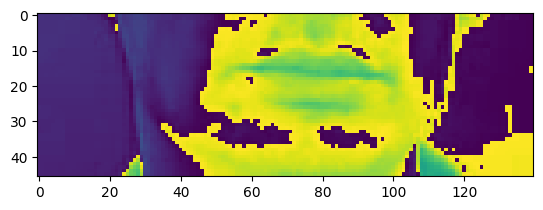

In [346]:
plt.imshow(frames[2])

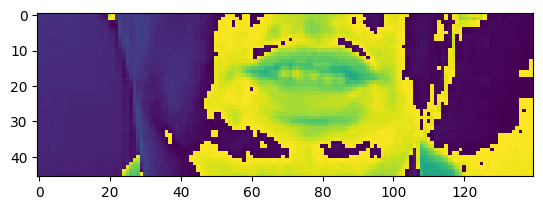

In [347]:
plt.imshow(frames[10])

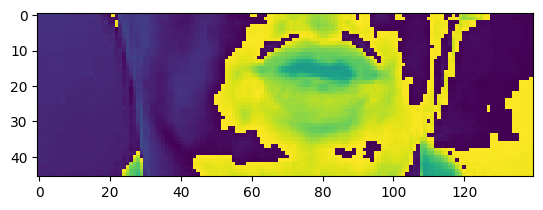

In [348]:
plt.imshow(frames[25])

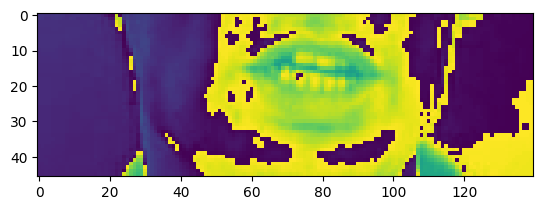

In [349]:
plt.imshow(frames[30])

In [350]:
# Convert numerical values in alignments tensor to characters and then decode bytes to strings
numerical_values = number2character(alignments.numpy()).numpy()
decoded_characters = [bytes.decode(x) for x in numerical_values]

# Join the decoded characters into a single string using TensorFlow's reduce_join function
joined_string = tf.strings.reduce_join(decoded_characters)

print(joined_string)

tf.Tensor(b'bin white in t one again', shape=(), dtype=string)


In [351]:
def depict_method(path:str) ->List[str]:
    result = tf.py_function(fetch_features, [path], (tf.float32, tf.int64))
    return result

In [352]:
def function_to_extract(path: str) -> List[str]:
    
    frames, alignments = fetch_features(path)
    
    frames_tensor = tf.convert_to_tensor(frames, dtype=tf.float32)
    alignments_tensor = tf.convert_to_tensor(alignments, dtype=tf.int64)
    
    return frames_tensor, alignments_tensor

In [404]:
dir = './data/s1/*.mpg'
input = tf.data.Dataset.list_files(dir)
print(input)
input = input.shuffle(500, reshuffle_each_iteration=False)
print(input)
input = input.map(depict_method)
print(input)
input = input.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
print(input)
input = input.prefetch(tf.data.AUTOTUNE)
print(input)

<_ShuffleDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>
<_ShuffleDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>
<_MapDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=<unknown>, dtype=tf.int64, name=None))>
<_PaddedBatchDataset element_spec=(TensorSpec(shape=(None, 75, None, None, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 40), dtype=tf.int64, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 75, None, None, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 40), dtype=tf.int64, name=None))>


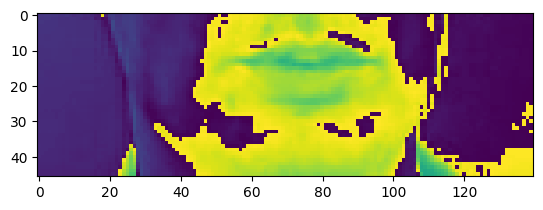

In [354]:
frames, alignments = input.as_numpy_iterator().next()
case = input.as_numpy_iterator()
item = case.next();
plt.imshow(item[0][1][42])

In [355]:
# Convert numerical values to characters and concatenate
characters = [number2character(word) for word in item[1][1]]
joined_characters = tf.strings.reduce_join(characters)

# To get the resulting string as a Python string
result_string = joined_characters.numpy().decode('utf-8')

# Print the resulting string
print(result_string)

place green with y nine soon


In [403]:
train_data = input.take(600)
test_data = input.skip(600)

In [389]:
# Define input shape
input_shape = input.as_numpy_iterator().next()[0][0].shape
input_layer = Input(shape=input_shape)

# Convolutional layers followed by max pooling
conv1 = Conv3D(128, 3, padding='same')(input_layer)
act1 = Activation('relu')(conv1)
maxpool1 = MaxPooling3D(pool_size=(1, 2, 2))(act1)

conv2 = Conv3D(256, 3, padding='same')(maxpool1)
act2 = Activation('relu')(conv2)
maxpool2 = MaxPooling3D(pool_size=(1, 2, 2))(act2)

conv3 = Conv3D(75, 3, padding='same')(maxpool2)
act3 = Activation('relu')(conv3)
maxpool3 = MaxPooling3D(pool_size=(1, 2, 2))(act3)

# Time distributed layer with Flatten
time_distributed = TimeDistributed(Flatten())(maxpool3)

# Bidirectional LSTM layers with dropout
bidir_lstm1 = Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True))(time_distributed)
dropout1 = Dropout(0.5)(bidir_lstm1)

bidir_lstm2 = Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True))(dropout1)
dropout2 = Dropout(0.5)(bidir_lstm2)

# Dense layer for classification
output_layer = Dense(character2number.vocabulary_size() + 1, kernel_initializer='he_normal', activation='softmax')(dropout2)

# Define the model
model = Model(inputs=input_layer, outputs=output_layer)


In [390]:
model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 75, 46, 140, 1)   0         
                             ]                                   
                                                                 
 conv3d_53 (Conv3D)          (None, 75, 46, 140, 128   3584      
                             )                                   
                                                                 
 activation_48 (Activation)  (None, 75, 46, 140, 128   0         
                             )                                   
                                                                 
 max_pooling3d_48 (MaxPooli  (None, 75, 23, 70, 128)   0         
 ng3D)                                                           
                                                                 
 conv3d_54 (Conv3D)          (None, 75, 23, 70, 256)   8849

In [359]:
prediction = model.predict(item[0])

1/1 [==============================] - 5s 5s/step


In [360]:
sequence = tf.argmax(prediction[0], axis=1)
characters = tf.map_fn(lambda x: number2character(x), sequence, dtype=tf.string)
joined_string = tf.strings.reduce_join(characters)

print(joined_string)

tf.Tensor(b'lllllllllllllllllllllllllllllllllllllllxllllllllllllllllllllllllllllllllddd', shape=(), dtype=string)


In [361]:
sequence = tf.argmax(prediction[0], axis=1)
characters = tf.map_fn(lambda x: number2character(x), sequence, dtype=tf.string)
joined_string = tf.strings.reduce_join(characters)

print(joined_string)

tf.Tensor(b'lllllllllllllllllllllllllllllllllllllllxllllllllllllllllllllllllllllllllddd', shape=(), dtype=string)


In [362]:
input_shape = model.layers[0].input_shape
print("Input shape:", input_shape)

Input shape: [(None, 75, 46, 140, 1)]


In [363]:
output_shape = model.layers[-1].output_shape
print("Output shape:", output_shape)

Output shape: (None, 75, 41)


In [365]:
# Credits Keras for this loss function.
# Link - https://keras.io/examples/audio/ctc_asr/

def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [366]:
class Give_sample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        self.dataset = dataset.as_numpy_iterator()
    
    def after_one_iteration(self, epoch, logs=None) -> None:
        input = self.dataset.next()
        prediction = self.model.predict(input[0])
        decoded = tf.keras.backend.ctc_decode(prediction, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(prediction)):           
            print('Real Text:', tf.strings.reduce_join(number2character(input[1][x])).numpy().decode('utf-8'))
            print('Predicted Text:', tf.strings.reduce_join(number2character(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [391]:
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.01), loss=CTCLoss)

In [392]:
checkpoint_callback = ModelCheckpoint(os.path.join('data','checkpoint'), monitor='loss', save_weights_only=True) 

In [393]:
example_callback = Give_sample(test_data)

In [397]:
history = model.fit(train_data, validation_data=test_data, epochs=90, callbacks=[checkpoint_callback, example_callback])

Epoch 1/10


 2/50 [>.............................] - ETA: 3:06 - loss: 159.3978

KeyboardInterrupt: 

In [398]:
history.history??

Type:        dict
String form: {'loss': [111.78915405273438, 84.3003158569336, 81.88460540771484, 84.72795867919922, 78.11873626708984, 80.15437316894531, 80.18865966796875, 79.29407501220703, 81.04737854003906, 81.59618377685547], 'val_loss': [90.22233581542969, 76.38137817382812, 99.73075103759766, 76.73982238769531, 100.55210876464844, 75.08866882324219, 75.95246887207031, 76.88838195800781, 112.6197738647461, 73.48566436767578]}
Length:      2
Docstring:  
dict() -> new empty dictionary
dict(mapping) -> new dictionary initialized from a mapping object's
    (key, value) pairs
dict(iterable) -> new dictionary initialized as if via:
    d = {}
    for k, v in iterable:
        d[k] = v
dict(**kwargs) -> new dictionary initialized with the name=value pairs
    in the keyword argument list.  For example:  dict(one=1, two=2)

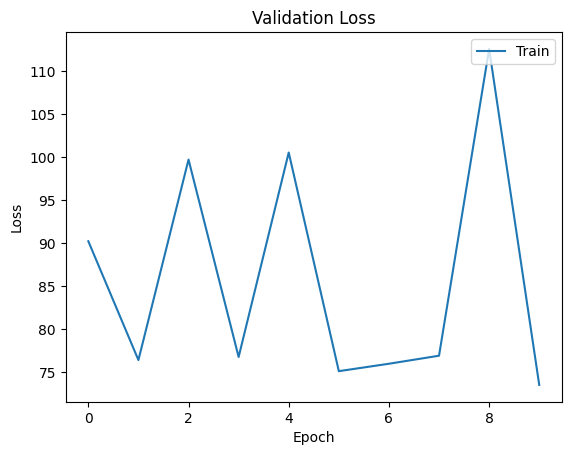

In [399]:
plt.plot(history.history['val_loss'])
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train'], loc='upper right')
plt.show()

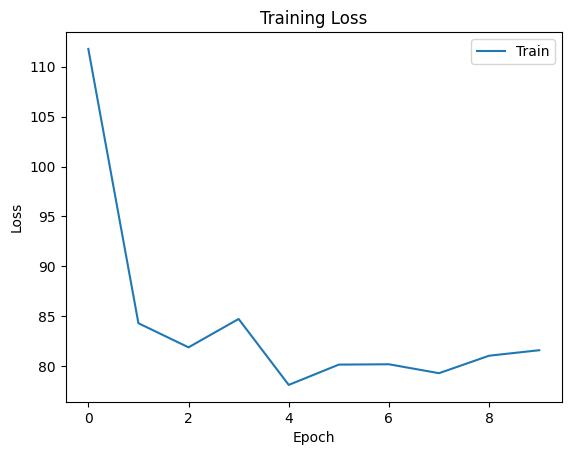

In [400]:
plt.plot(history.history['loss'])
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train'], loc='upper right')
plt.show()

In [401]:
test = test_data.as_numpy_iterator()

In [378]:
case = test.next()

In [402]:
prediction = model.predict(case[0])

1/1 [==============================] - 3s 3s/step


In [405]:
converted_sentences = []

for sentence in case[1]:
    char_list = []
    for word in sentence:
        character = number2character(word)
        char_list.append(character)
    converted_sentence = tf.strings.reduce_join(char_list)
    converted_sentences.append(converted_sentence)

print('Real Ouput')
print(converted_sentences[0])
print(converted_sentences[1])

Real Ouput
tf.Tensor(b'place green with l two please', shape=(), dtype=string)
tf.Tensor(b'bin white by n three soon', shape=(), dtype=string)


In [381]:
decoded = tf.keras.backend.ctc_decode(prediction, input_length=[75,75], greedy=True)[0][0].numpy()

In [406]:
converted_sentences = []

for sentence in decoded:
    char_list = []
    for word in sentence:
        character = number2character(word)
        char_list.append(character)
    converted_sentence = tf.strings.reduce_join(char_list)
    converted_sentences.append(converted_sentence)

print('Predicted Ouput')
print(converted_sentences[0])
print(converted_sentences[1])

Predicted Ouput
tf.Tensor(b'place green with l two please', shape=(), dtype=string)
tf.Tensor(b'bin white by n three soon', shape=(), dtype=string)
